In [1]:
from __future__ import annotations

import os
import os.path as P
import typing

import cloudpickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import (
    FunctionTransformer,
    MinMaxScaler,
    OneHotEncoder,
    StandardScaler,
)

# Data Preprocessing Strategy

In the last notebook, after executing our Exploratory Data Analysis, we applied a simple data preprocessing strategy and built our baseline model based on a [Ridge regressor](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html). In this notebook we'll focus on enhancing the preprocess pipeline to make it full use of the available data. At the end we'll check how our new features will correlate with each other and the effectiveness of the new approach by traning a new Ridge regressor model.

## Data Loading

Here we just load our previously cleaned data

In [2]:
preprocessed_dataset_root_dir = P.join(P.dirname(P.abspath("")), "data", "processed")

In [3]:
df_file = P.join(preprocessed_dataset_root_dir, "sp_sales_data.parquet")

features = pd.read_parquet(df_file)
features

,neighborhood,property_type,usable_area,bathrooms,suites,bedrooms,parking_spots,ad_date,sale_price,condominium_fee,annual_iptu_tax
0,Jardim da Saude,Two-story House,388.0,3.0,1.0,4.0,6.0,2017-02-07,700000,NaN,NaN
1,Vila Santa Teresa (Zona Sul),House,129.0,2.0,1.0,3.0,2.0,2016-03-21,336000,NaN,NaN
2,Vila Olimpia,Apartament,80.0,2.0,1.0,3.0,2.0,2018-10-26,739643,686.0,1610.0
3,Pinheiros,Apartament,94.0,1.0,0.0,3.0,2.0,2018-05-29,630700,1120.0,489.0
4,Vila Santa Clara,Condominium,110.0,1.0,1.0,3.0,2.0,2018-04-16,385000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
88742,Vila Carmosina,Apartament,48.0,1.0,0.0,2.0,1.0,2017-10-07,171150,244.0,0.0
88743,Bela Vista,Apartament,60.0,1.0,NaN,1.0,1.0,2017-12-13,251999,273.0,86.0
88744,Liberdade,Apartament,53.0,2.0,1.0,2.0,1.0,2018-11-28,249782,210.0,0.0
88745,Vila Lageado,Apartament,20.0,3.0,2.0,3.0,2.0,2019-02-06,623000,NaN,NaN


We'll also isolate our target feature (`sale_price`).

In [4]:
prices = features.pop("sale_price")

display(features)
display(prices)

,neighborhood,property_type,usable_area,bathrooms,suites,bedrooms,parking_spots,ad_date,condominium_fee,annual_iptu_tax
0,Jardim da Saude,Two-story House,388.0,3.0,1.0,4.0,6.0,2017-02-07,NaN,NaN
1,Vila Santa Teresa (Zona Sul),House,129.0,2.0,1.0,3.0,2.0,2016-03-21,NaN,NaN
2,Vila Olimpia,Apartament,80.0,2.0,1.0,3.0,2.0,2018-10-26,686.0,1610.0
3,Pinheiros,Apartament,94.0,1.0,0.0,3.0,2.0,2018-05-29,1120.0,489.0
4,Vila Santa Clara,Condominium,110.0,1.0,1.0,3.0,2.0,2018-04-16,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
88742,Vila Carmosina,Apartament,48.0,1.0,0.0,2.0,1.0,2017-10-07,244.0,0.0
88743,Bela Vista,Apartament,60.0,1.0,NaN,1.0,1.0,2017-12-13,273.0,86.0
88744,Liberdade,Apartament,53.0,2.0,1.0,2.0,1.0,2018-11-28,210.0,0.0
88745,Vila Lageado,Apartament,20.0,3.0,2.0,3.0,2.0,2019-02-06,NaN,NaN


0         700000
1         336000
2         739643
3         630700
4         385000
          ...   
88742     171150
88743     251999
88744     249782
88745     623000
88746    1820000
Name: sale_price, Length: 88747, dtype: int64

## The Sklearn's set_output API

The design of the whole data preprocessing pipeline is based with modularity in mind: each processing step is Sklearn's **transform** that can be combined or stacked with one another. For this we'll use one of the Sklearn's newest and most useful feature introduced in [version 1.2](https://scikit-learn.org/stable/auto_examples/release_highlights/plot_release_highlights_1_2_0.html): the ability to output Pandas dataframes from any estimator/transformer, through the [set_output API](https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_set_output.html#introducing-the-set-output-api).

We can activate this feature by setting the `set_output(transform="pandas")` method of any estimator or by setting int globaly, by running the following cell.

In [5]:
sklearn.set_config(transform_output="pandas")

## Basic Feature Imputing

First of all, we have to deal with the missing values. The approach is pretty basic:
- For `condominium_fee`, `suites`, `parking_spots`, `bedrooms` e `bathrooms`, it makes sense that a missing value represents the literal absence of this feature.
- For `annual_iptu_tax` and `usable_area`, for obvious reasons, we'll consider missing values as errors in data collection process and, as we don't have a better plan, we'll fill those values with the **mean of the corresponding feature**.

In [6]:
imputing_transformer = make_column_transformer(
    (
        SimpleImputer(fill_value=0.0),
        [
            "condominium_fee",
            "suites",
            "parking_spots",
            "bedrooms",
            "bathrooms"
        ]
    ), (
        SimpleImputer(strategy="mean"),
        ["annual_iptu_tax", "usable_area"]
    ),
    remainder="passthrough",
    verbose_feature_names_out=False
)

The use of [SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html) does'nt need an explanation. The remainder parameter of [make_column_transformer](https://scikit-learn.org/stable/modules/generated/sklearn.compose.make_column_transformer.html) just tells that the `reminder` features will be outputer as they are. As for `get_feature_names_out`, if `True`, will prefix all feature names with the name of the transformer that generated that feature. Otherwise, feature names won't be prefixed (just be careful and make sure that all names are unique).

Now let's use our first pipeline to check what it outputs.

In [7]:
imputing_transformer.fit_transform(features)

,condominium_fee,suites,parking_spots,bedrooms,bathrooms,annual_iptu_tax,usable_area,neighborhood,property_type,ad_date
0,987.804458,1.000000,6.0,4.0,3.0,734.084966,388.0,Jardim da Saude,Two-story House,2017-02-07
1,987.804458,1.000000,2.0,3.0,2.0,734.084966,129.0,Vila Santa Teresa (Zona Sul),House,2016-03-21
2,686.000000,1.000000,2.0,3.0,2.0,1610.000000,80.0,Vila Olimpia,Apartament,2018-10-26
3,1120.000000,0.000000,2.0,3.0,1.0,489.000000,94.0,Pinheiros,Apartament,2018-05-29
4,0.000000,1.000000,2.0,3.0,1.0,0.000000,110.0,Vila Santa Clara,Condominium,2018-04-16
...,...,...,...,...,...,...,...,...,...,...
88742,244.000000,0.000000,1.0,2.0,1.0,0.000000,48.0,Vila Carmosina,Apartament,2017-10-07
88743,273.000000,1.062818,1.0,1.0,1.0,86.000000,60.0,Bela Vista,Apartament,2017-12-13
88744,210.000000,1.000000,1.0,2.0,2.0,0.000000,53.0,Liberdade,Apartament,2018-11-28
88745,987.804458,2.000000,2.0,3.0,3.0,734.084966,20.0,Vila Lageado,Apartament,2019-02-06


As you can see, the resulting dataframe preserves all feature names.

This is all the imputing we need to execute. Now we'll create some new features.

# Feature Engineering

Every new feature will be created using the [Sklearn's FunctionTransformer API](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.FunctionTransformer.html). For this, we'll just need to define some transformation functions, that takes a dataframe as input and deliver the transformed dataframe as output.

## General tax

We'll create a general tax feature, that represents houghly the monthly cost in taxes of the property.

In [8]:
def add_general_tax(X: pd.DataFrame) -> pd.DataFrame:
    general_tax = pd.DataFrame()
    
    general_tax["general_tax"] = X["condominium_fee"] + X["annual_iptu_tax"] / 12
    
    return general_tax

As you can see, I decided to, at every step, return only the newly created features. This is what we call a **functional transformer**. I found that this approach is the best in terms of interpretability and debbuging, as every feature creation function works independently from each other. Soon I'll show how can we use this function to compose the final dataframe.

## Area Score

We'll also define a type of score of the property based on how much the property area costs.

In [9]:
def add_area_score(X: pd.DataFrame) -> pd.DataFrame:
    area_scores = pd.DataFrame()
    
    area_scores["general_tax_score"] = X["general_tax"] / X["usable_area"]
    
    return area_scores

## Number of Property Features

We'll also add a set of columns that represents the presence of a specific house feature (suites, parking spots, bedrooms and bathrooms) e a column with the number of features present in a house.

In [10]:
def add_number_of_features(X: pd.DataFrame) -> pd.DataFrame:
    n_features = pd.DataFrame()
    
    features = ["suites", "parking_spots", "bedrooms", "bathrooms"]
    
    for feat in ["suites", "parking_spots", "bedrooms", "bathrooms"]:
        n_features["has_" + feat] = (X[feat] > 0).astype(int)
    
    n_features["n_features"] = n_features[["has_" + feat for feat in features]].sum(axis="columns")
    
    return n_features

## Neighborhoodhood Scores

We'll also create scores based on the area value of the property's neighborhood.
- `neighborhood_general_tax_score`: the average condominium general tax per area billed for the neighborhood properties.

This time well create our transformer a bit different.

In [11]:
class NeighborhoodScores(BaseEstimator, TransformerMixin):
    def __init__(self) -> None:
        super().__init__()

        self.neighborhood_metrics = None
        self.general_tax_score_mean = None

    def fit(
        self, X: pd.DataFrame, y: typing.Optional[typing.Any] = None
    ) -> NeighborhoodScores:
        required_cols = X[["neighborhood", "general_tax_score"]].copy()
        required_cols["neighborhood"] = required_cols["neighborhood"].apply(self._normalize_str)
        self.neighborhood_metrics = required_cols.groupby("neighborhood").mean()
        self.neighborhood_metrics.columns = ["neighborhood_general_tax_score"]

        self.general_tax_score_mean = self.neighborhood_metrics.mean()[0]

        return self

    def transform(
        self, X: pd.DataFrame, y: typing.Optional[typing.Any] = None
    ) -> pd.DataFrame:
        neighs_scores = X[["neighborhood", "general_tax_score"]].copy()
        neighs_scores["neighborhood"] = neighs_scores["neighborhood"].apply(self._normalize_str)

        joinded_df = neighs_scores.join(
            self.neighborhood_metrics, on="neighborhood", how="left"
        )
        
        result = pd.DataFrame()
        result["neighborhood_general_tax_score"] = joinded_df["neighborhood_general_tax_score"].fillna(self.general_tax_score_mean)
        
        return result

    def _normalize_str(self, string: str) -> str:
        return string.lower().strip()

OK. That one was a bit tricky! I'll try to answer that may come in mind when first looking at this class.

### Why do we need a class instead of a plain function?
In opposed to the **function transformer**, this one needs to retain some kind of **memory**: we need to keep the neighboor's condominium and iptu data to used in new data.

### Why do we subclass from Sklearn's BaseEstimator?
By deriving from [BaseEstimator](https://scikit-learn.org/stable/modules/generated/sklearn.base.BaseEstimator.html), we make our transformer compatible with Sklean's API by providing a common interface to get the transformer's parameters (through the `get_params` method) and to set parameters (through the `set_params` method).

### Why do we subclass from Sklearn's TransformerMixin?
By deriving from [TransformerMixin](https://scikit-learn.org/stable/modules/generated/sklearn.base.TransformerMixin.html), our transformer supply a common interface for training (through the `fit` method) and for transforming new data (through the `transform` method). As a bonus, we also get the `fit_transform` method, that fit's the transformer and transforms the train data in one go.

### How this transformer works?
1. In training phase, we compute the average general taxes per property area for each neighboorhood and put it in a table. We also compute the global average general tax per area.

2. In transforming phase, we join our table with the new data using the neighboor name as key and fill missing values (neighboors that we don't have data) with the global average of the general tax per area.

## Feature Transformation

With all features (old and new ones) in hand, we'll prepare them to be properly used to train our models. In this step involves:
- **Transform nominal features to numerical ones:** Most of the Machine Learning that we'll design only accept numbers. Feature `property_type` on the other hand, holds values that verbosely represents the property types. For this we'll apply the [One-hot Encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) techinique: a new column will be created for each of `property_type` values, and each column will be a boolean value that represents if the property is/isn't of the corresponding type.
- **Standard Scalling:** The difference of values scales between features impact greatly in most of Machine Learning algorithms. Thus, each numeric feature will be transformed using the [Standard Scalling](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) method: for a specific feature, it's values will be subtracted by it's average value and next divided by it's standard deviation.

As before, this step will be implemented usign the Sklearn's API. Let's proceed to do it.

## Putting Everything Together

In [12]:
feature_engineering_pipeline = make_pipeline(
    make_column_transformer(
        (
            SimpleImputer(fill_value=0.0),
            ["condominium_fee", "suites", "parking_spots", "bedrooms", "bathrooms"],
        ),
        (SimpleImputer(strategy="mean"), ["annual_iptu_tax", "usable_area"]),
        remainder="passthrough",
        verbose_feature_names_out=False,
    ),
    make_union("passthrough", FunctionTransformer(add_general_tax)),
    make_union("passthrough", FunctionTransformer(add_area_score)),
    make_union("passthrough", NeighborhoodScores()),
    make_union("passthrough", FunctionTransformer(add_number_of_features)),
    FunctionTransformer(
        lambda X: X.drop(
            [
                "neighborhood",
                "ad_date",
                "condominium_fee",
                "annual_iptu_tax",
                "general_tax",
                "general_tax_score",
            ],
            axis="columns",
        )
    ),
    make_column_transformer(
        (OneHotEncoder(sparse_output=False), ["property_type"]),
        (
            StandardScaler(),
            [
                "usable_area",
                "neighborhood_general_tax_score",
            ],
        ),
        remainder=MinMaxScaler(),
        verbose_feature_names_out=False,
    ),
)

As you can see, with all feature engineering functions defined, it's easy to arrange all steps that we've mentioned in a sequential order of a pipeline. Note the use of [FunctionTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.FunctionTransformer.html) to encapsulate our previously created functions to integrate them in our pipeline. **FunctionTransformer** is also used to create simple and stateless transformation e.g.: drop columns.

Now, to use our pipeline, we must train it. After that we can transform any new data that it receives as input. We can accomplish these two steps in one go with `fit_transform` method.

In [13]:
transformed_features = feature_engineering_pipeline.fit_transform(features)

transformed_features

,property_type_Apartament,property_type_Condominium,property_type_Flat,property_type_House,property_type_Penthouse,property_type_Residential Building,property_type_Studio Apartament,property_type_Two-story House,usable_area,neighborhood_general_tax_score,suites,parking_spots,bedrooms,bathrooms,has_suites,has_parking_spots,has_bedrooms,has_bathrooms,n_features
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.039322,3.167133,0.166667,0.857143,0.8,0.428571,1.0,1.0,1.0,1.0,1.00
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.229577,-0.203310,0.166667,0.285714,0.6,0.285714,1.0,1.0,1.0,1.0,1.00
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.491186,0.996450,0.166667,0.285714,0.6,0.285714,1.0,1.0,1.0,1.0,1.00
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.285254,0.605658,0.000000,0.285714,0.6,0.142857,0.0,1.0,1.0,1.0,0.75
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.049903,-0.336893,0.166667,0.285714,0.6,0.142857,1.0,1.0,1.0,1.0,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88742,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.961888,-0.350581,0.000000,0.142857,0.4,0.142857,0.0,1.0,1.0,1.0,0.75
88743,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.785375,-0.147720,0.177136,0.142857,0.2,0.142857,1.0,1.0,1.0,1.0,1.00
88744,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.888341,-0.193948,0.166667,0.142857,0.4,0.285714,1.0,1.0,1.0,1.0,1.00
88745,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.373752,-0.187093,0.333333,0.285714,0.6,0.428571,1.0,1.0,1.0,1.0,1.00


As mentioned before, the pipeline output is a pandas dataframe, with all original column's names, plus the new columns, one for each property type.

## Target Transform

We'll also transform the target feature by taking the `log` of it's values. This will be usefull for two reasons:
1. [It reduces the skewness of the feature distribution, giving it a more "normal" shape.](https://medium.com/@kyawsawhtoon/log-transformation-purpose-and-interpretation-9444b4b049c9).
2. It ensures that the model that we'll build in a moment won't output negative values (the Mean Squared Logarithmic Error doesn't accept negatives).

In [14]:
target_transform = FunctionTransformer(np.log, inverse_func=np.exp)
transformed_prices = target_transform.transform(prices.to_frame())
transformed_prices

,sale_price
0,13.458836
1,12.724866
2,13.513923
3,13.354586
4,12.860999
...,...
88742,12.050296
88743,12.437180
88744,12.428344
88745,13.342302


Again, We make use of `FunctionTransformer` to encasulate the transformation function. This time, we also supplied the `inverse_func` param, that defines the inverse function of the transformation (in this case, the `exponential` function). This will be usefull when we transform our predicted values back to the original target feature space.

# New Features correlation

Let's check how the transformed features correlate with each other and the target feature.

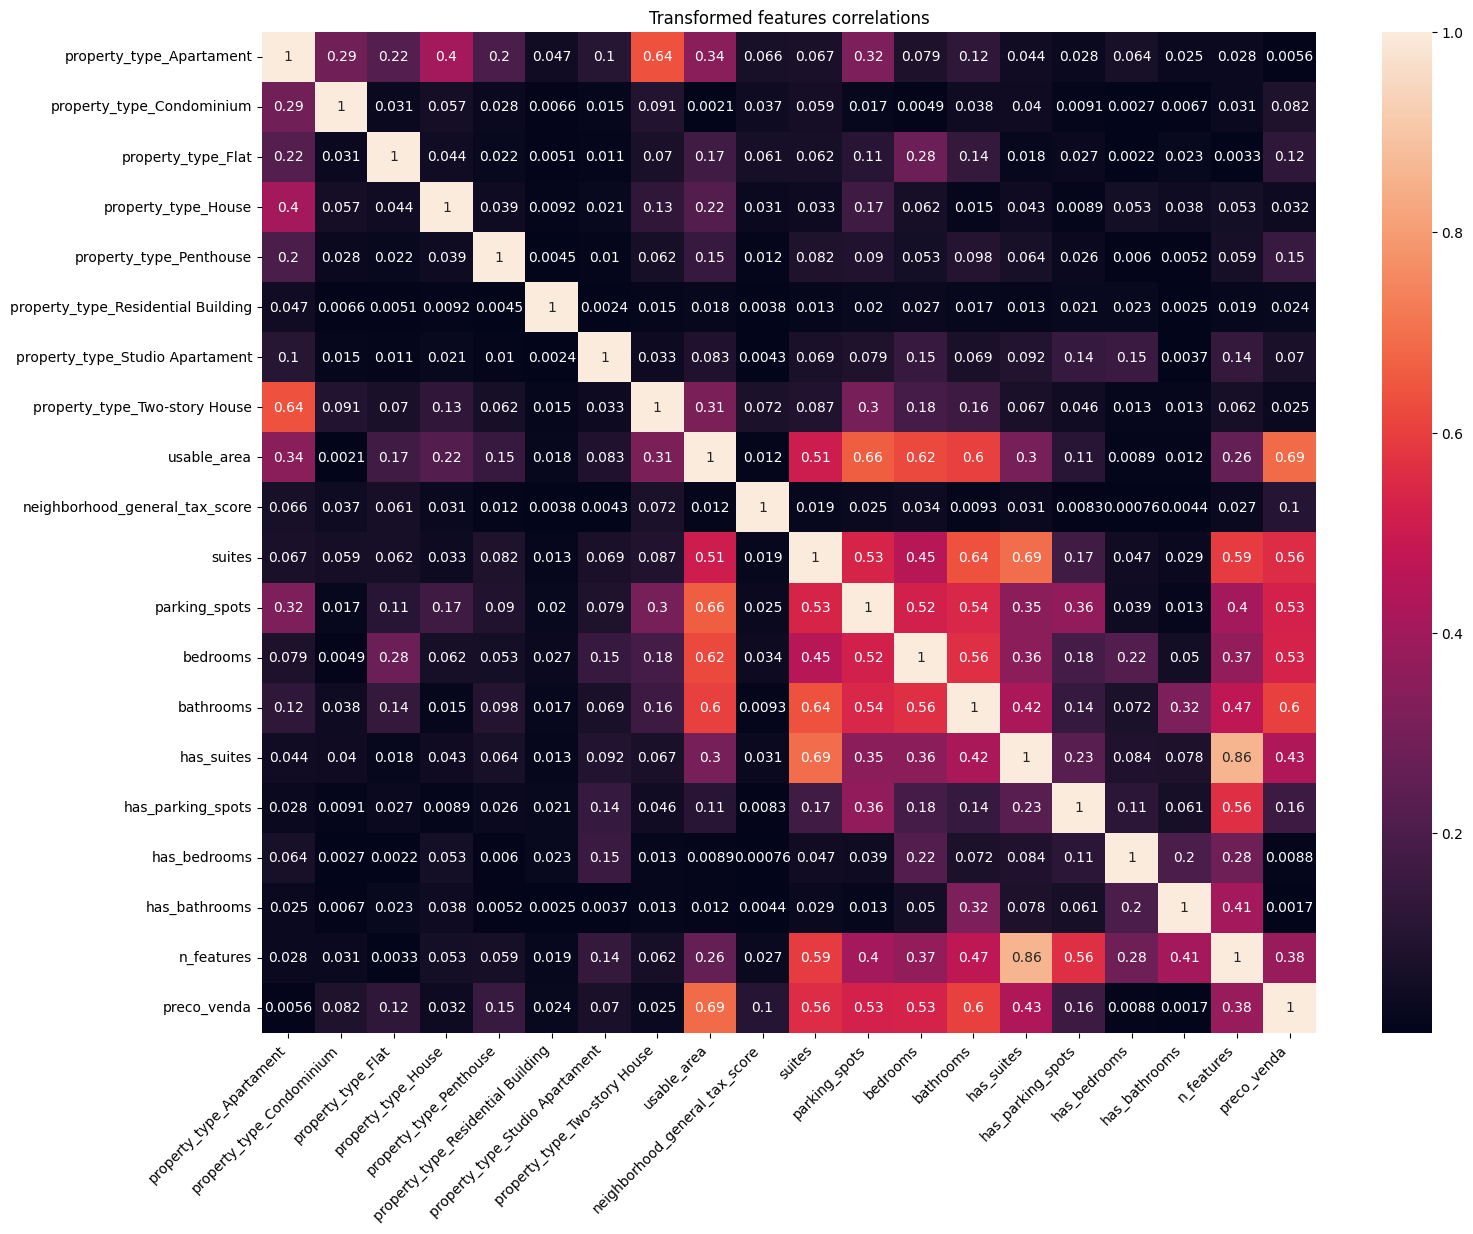

In [15]:
tmp_df = transformed_features.copy()
tmp_df["preco_venda"] = transformed_prices

corrs = tmp_df.corr().abs()

plt.figure(figsize=(17, 13))
plt.title("Transformed features correlations")
sns.heatmap(corrs, annot=True)
plt.xticks(rotation=45, ha="right");

- Transformation on features `usable_are`, `suites`, `parking_spots`, `bedrooms` and `bathrooms`, that already have high correlation with the target feature, has increased these correlations even more.
- The presence of `suites` in a property have a bit of a impact on the pouse price. `parking_spots` also have, but the impact is weaker.
- For the other created features, none of them have a high correlation with the target feature, but they will support the design of the regression model anyway, as we'll see next.

# Improved Baseline Model
Again, we'll train a [Ridge regressor](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html)  model. Our purpose we'll be to assess the processed features and check if we have an improvement in accuracy.

In [16]:
ridge_reg = Ridge()
ridge_reg.fit(transformed_features, transformed_prices)

Ridge()

Now, we'll make our predictions. Note that, as we said before, the model was trained using the transformed target feature, so the predictions are in the `log` space. Thus, we'll use the **inverse transform** of the target transform to bring those predictions to the normal **prices** space.

In [17]:
predictions = ridge_reg.predict(transformed_features)
transformed_predictions = target_transform.inverse_transform(predictions)

Now we'll use compute the [Mean Squared Logarithmic Error](https://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-logarithmic-error) to assess the model accuracy.

In [18]:
msle = mean_squared_log_error(prices, transformed_predictions)
print(f"Mean Squared Logarithmic Error: {msle}")

Mean Squared Logarithmic Error: 0.13910249889196857


Our new error is of 0.1391, which is an improvement in relation to our baseline error (0.1738).

# Exporting the Preprocessing Pipeline

To enable the use of the transformation function that we defined in other notebooks/standalone code. You may have heard of [pickle](https://docs.python.org/3/library/pickle.html), but for Data Scientists that already have some knowledge about it, it's clear that **it won't be sufficient**, as [pickle can only serialize it by reference](https://github.com/cloudpipe/cloudpickle#:~:text=pickle%20can%20only%20serialize%20it%20by%20reference).

There are some ways to accomplish an effective serialization of complex Python constructs (as our preprocess pipeline), but here I'll use [cloudpickle](https://github.com/cloudpipe/cloudpickle).

Let's begin by creating the folder where we'll serialize our objects.

In [19]:
artifacts_root_dir = P.join(P.dirname(P.abspath("")), "artifacts")

if not P.isdir(artifacts_root_dir):
    os.makedirs(artifacts_root_dir)

Now, it's easy to create our artifact with cloudpickle: we use it's `dump` function, exactly like the `pickle` module.

In [20]:
preprocessing_pipeline_path = P.join(
    artifacts_root_dir, "preprocessing_pipeline.pickle"
)

with open(preprocessing_pipeline_path, "wb") as f:
    cloudpickle.dump(feature_engineering_pipeline, f)

Done! Easy as that! We'll also serialize our target transformer.

In [21]:
target_transform_path = P.join(
    artifacts_root_dir, "target_transform.pickle"
)

with open(target_transform_path, "wb") as f:
    cloudpickle.dump(target_transform, f)

And that's it. In the next notebook I'll show how to deserialize the created artifacts and retrieve our objects.